In [1]:
!pip install wheel==0.37.1 setuptools==59.6.0
!pip install gym[atari,accept-rom-license]==0.21.0 tensorflow-probability==0.19.0 tqdm==4.64.1

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from math import ceil
from typing import Iterable, Tuple, List, Callable
from dataclasses import dataclass

import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.layers import \
    Layer, Input, Conv2D, Conv2DTranspose, Lambda, \
    Dropout, Reshape, Flatten, Dense

In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.11.0
/device:GPU:0


In [4]:
@dataclass
class DreamerSettings:
    action_dims: List[int]
    obs_dims: List[int]
    repr_dims: List[int]
    hidden_dims: List[int]
    enc_dims: List[int]
    dropout_rate: float = 0.2
    codebook_size: int = 32

    @property
    def repr_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1]

    @property
    def repr_out_dims_flat(self) -> int:
        return self.repr_dims[0] * self.repr_dims[1] + self.hidden_dims[0]

In [5]:
def sample_obs(env: gym.Env, num_obs: int, proprocess_image) -> tf.data.Dataset:
    all_obs = []
    done = False
    obs = env.reset()
    all_obs.append(proprocess_image(obs))
    while len(all_obs) < num_obs:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        all_obs.append(proprocess_image(obs))
        if done and len(all_obs) < num_obs:
            obs = env.reset()
            all_obs.append(proprocess_image(obs))
    return tf.data.Dataset.from_tensor_slices(tensors=(np.array(all_obs)))


def generate_datasets(
        env: gym.Env, settings: DreamerSettings,
        batch_size: int, timesteps: int):

    def preprocess(obs):
        obs = tf.image.resize(obs, settings.obs_dims[:2])
        return tf.cast(obs, dtype=tf.float32) / 255.0

    dataset = sample_obs(env, timesteps, preprocess)
    dataset = dataset.map(lambda obs: (obs, obs))
    dataset = dataset.batch(batch_size)
    num_eval_batches = ceil((timesteps // batch_size) * 0.1)
    train_dataset = dataset.skip(num_eval_batches)
    eval_dataset = dataset.take(num_eval_batches)
    train_dataset = train_dataset.shuffle(100)
    return train_dataset, eval_dataset

In [6]:
class VectorQuantizer(Layer):
    """Adaptation of the vectorization quantization layer for learning
    a latent space consisting of a given amount of classifications
    with a given amount of classes each. Each classification has a distinct
    codebook with an embedding for each subclass, resulting in a codebook
    size of num_classifications * num_classes."""

    def __init__(
            self, num_classifications: int, num_classes: int,
            name: str="vector_quantizer"):
        super().__init__(name=name)
        self.num_classifications = num_classifications
        self.num_classes = num_classes
        self.num_embeddings = num_classifications * num_classes

    def build(self, input_shape: Iterable[int]):
        input_dims_flat = tf.reduce_prod(input_shape[1:])
        self.embedding_dims = input_dims_flat // self.num_classifications
        self.embeddings = self._build_embeddings(self.num_embeddings, self.embedding_dims)

        if input_dims_flat % self.num_classifications != 0:
            raise ValueError((
                f"The input dimensions {input_dims_flat} must be divisible "
                f"by the number of classifications {self.num_classifications} "
                f"to support swapping each of the {self.num_classifications} slices "
                "from the input vector with a quantized vector from the codebook."))

    def call(self, x: tf.Tensor):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, (input_shape[0], -1, self.embedding_dims))

        categoricals_sparse = self._most_similar_embeddings(flattened)
        # categoricals = tf.one_hot(categoricals_sparse, self.num_classes) # info: this is z

        id_offsets = tf.range(0, self.num_classifications, dtype=tf.int64) * self.num_classes
        categoricals_embed_sparse = categoricals_sparse + id_offsets
        categoricals_embed = tf.one_hot(categoricals_embed_sparse, depth=self.num_embeddings)

        quantized = tf.matmul(categoricals_embed, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)
        return quantized #, categoricals

    def _most_similar_embeddings(self, inputs: tf.Tensor):
        shape = (-1, self.num_classifications, self.num_classes)
        embeddings_per_classification = tf.reshape(self.embeddings, shape)
        codebook_ids = []

        for i in range(self.num_classifications):
            embeddings = embeddings_per_classification[:, i, :]
            inputs_classif = inputs[:, i, :]

            inputs_sqsum = tf.reduce_sum(inputs_classif ** 2, axis=1, keepdims=True)
            embed_sqsum = tf.reduce_sum(embeddings ** 2, axis=0)
            similarity = tf.matmul(inputs_classif, embeddings)
            distances = inputs_sqsum + embed_sqsum - 2 * similarity

            class_ids = tf.argmin(distances, axis=1, output_type=tf.int64)
            codebook_ids.append(tf.expand_dims(class_ids, axis=0))

        codebook_ids = tf.concat(codebook_ids, axis=0)
        codebook_ids = tf.transpose(codebook_ids, perm=[1, 0])
        return codebook_ids

    def _build_embeddings(self, num_embeddings: int, embedding_dims: int):
        embed_shape = (embedding_dims, num_embeddings)
        w_init = tf.random_uniform_initializer()
        embed_w = w_init(shape=embed_shape, dtype=tf.float32)
        return tf.Variable(embed_w, True, name="embeddings")

In [7]:
def create_encoder(settings: DreamerSettings) -> Model:
    model_in = Input(settings.obs_dims, name="obs")
    norm_img = Lambda(lambda x: x * 2.0 - 1.0)
    cnn_1 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_4 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_5 = Conv2D(64, (3, 3), padding="same", activation="elu")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    drop_4 = Dropout(rate=settings.dropout_rate)

    img_in = norm_img(model_in)
    model_out = cnn_5(drop_4(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(img_in)))))))))
    return Model(inputs=model_in, outputs=model_out, name="encoder_model")


def create_decoder(settings: DreamerSettings) -> Model:
    image_channels = settings.obs_dims[-1]
    in_height, in_width = settings.obs_dims[0] // 16, settings.obs_dims[1] // 16
    upscale_source_dims = in_height * in_width * 64

    model_in = Input(settings.enc_dims[0], name="repr_out")
    #dense_in = Dense(upscale_source_dims, activation="linear", name="dec_in")
    reshape_in = Reshape((in_height, in_width, -1))
    cnn_1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_5 = Conv2D(image_channels, (1, 1), padding="same", activation="linear")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)

    prep_in = reshape_in(model_in)
    model_out = cnn_5(cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(prep_in))))))))
    return Model(inputs=model_in, outputs=model_out, name="decoder_model")


def compose_vqvae(settings: DreamerSettings) -> Tuple[Model, Model]:
    vq_layer = VectorQuantizer(settings.repr_dims[0], settings.repr_dims[1])
    encoder = create_encoder(settings)
    decoder = create_decoder(settings)
    flatten = Flatten()

    model_in = Input(shape=settings.obs_dims, name="img_orig")
    z_enc = encoder(model_in)
    z_quantized = vq_layer(z_enc)
    z_st_quantized = z_enc + tf.stop_gradient(z_quantized - z_enc)
    x_reconst = decoder(flatten(z_st_quantized))

    vqvae_train = Model(inputs=[model_in], outputs=[x_reconst, z_enc, z_quantized], name="vqvae")
    vqvae_infer = Model(inputs=[model_in], outputs=[x_reconst], name="vqvae")
    return vqvae_train, vqvae_infer


def create_model(settings: DreamerSettings) -> Tuple[Model, Model]:
    model_train, model_infer = compose_vqvae(settings)
    model_train.build([None] + settings.obs_dims)
    model_train.summary()
    return model_train, model_infer

In [8]:
TrainBatch = Tuple[tf.Tensor, tf.Tensor]
Datasets = Tuple[tf.data.Dataset, tf.data.Dataset]


@tf.function
def train_step(
        model: Model, optimizer: Optimizer, batch: TrainBatch,
        committment_cost: float=0.25, data_variance: float=1.0):

    x, y_true = batch
    with tf.GradientTape() as tape:
        reconst, z_enc, z_quantized = model(x)

        committment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
        codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
        vqvae_loss = committment_cost * committment_loss + codebook_loss

        reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / data_variance
        total_loss = reconst_loss + vqvae_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return vqvae_loss, reconst_loss


@tf.function
def eval_step(
        model: Model, batch: TrainBatch,
        committment_cost: float=0.25, data_variance: float=1.0):

    x, y_true = batch
    reconst, z_enc, z_quantized = model(x)

    committment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
    codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
    vqvae_loss = committment_cost * committment_loss + codebook_loss

    reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / data_variance
    total_loss = reconst_loss + vqvae_loss
    return vqvae_loss, reconst_loss


class LossLogger:
    def __init__(self):
        self.writer = tf.summary.create_file_writer("logs/vae")
        self.vqvae_loss_mean = Mean()
        self.reconst_loss_mean = Mean()
        self.total_loss_mean = Mean()

    def log_losses(self, vqvae_loss: float, reconst_loss: float):
        total_loss = reconst_loss + vqvae_loss
        self.vqvae_loss_mean(vqvae_loss)
        self.reconst_loss_mean(reconst_loss)
        self.total_loss_mean(total_loss)

    def flush_losses(self, step: int, mode: str):
        with self.writer.as_default():
            tf.summary.scalar(f"{mode}/vqvae_loss", self.vqvae_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/reconst_loss", self.reconst_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/total_loss", self.total_loss_mean.result(), step=step)
        self.vqvae_loss_mean.reset_state()
        self.reconst_loss_mean.reset_state()
        self.total_loss_mean.reset_state()


def train(settings: DreamerSettings, epochs: int, datasets: Datasets):
    train_dataset, test_dataset = datasets
    model_train, model_infer = create_model(settings)
    optimizer = Adam()
    loss_logger = LossLogger()
    cost = 0.25

    for ep in tqdm(range(epochs)):
        for batch in train_dataset:
            vqvae_loss, reconst_loss = train_step(model_train, optimizer, batch, cost)
            loss_logger.log_losses(vqvae_loss, reconst_loss)
        loss_logger.flush_losses(ep + 1, "train")

        for batch in test_dataset:
            vqvae_loss, reconst_loss = eval_step(model_train, batch, cost)
            loss_logger.log_losses(vqvae_loss, reconst_loss)
        loss_logger.flush_losses(ep + 1, "eval")

    return model_infer


settings = DreamerSettings([1], [64, 64, 3], [32, 32], [512], [1024])
env = gym.make("ALE/Pacman-v5")
train_dataset, test_dataset = generate_datasets(env, settings, 128, 10_000)
model = train(settings, 1000, (train_dataset, test_dataset))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "vqvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_orig (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_model (Functional)     (None, 4, 4, 64)     149504      ['img_orig[0][0]']               
                                                                                                  
 vector_quantizer (VectorQuanti  (None, 4, 4, 64)    32768       ['encoder_model[0][0]']          
 zer)                                                                                      

100%|██████████| 1000/1000 [55:18<00:00,  3.32s/it]


2/2 [==============================] - 1s 90ms/step


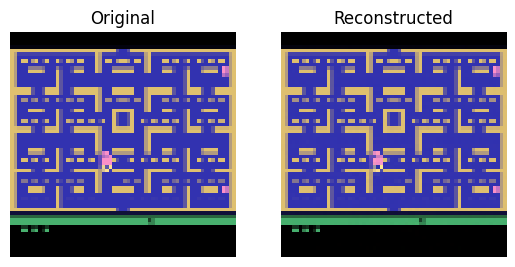

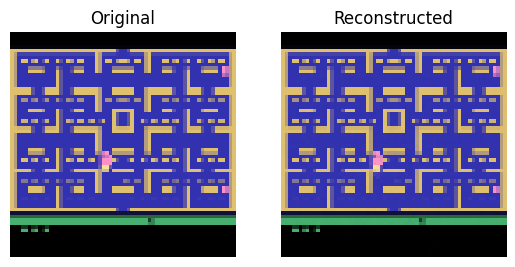

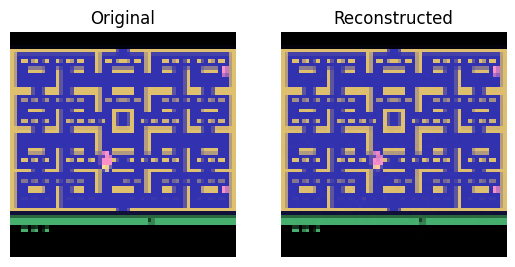

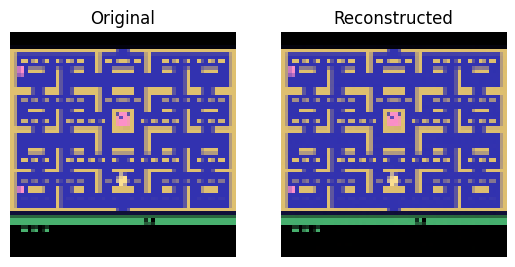

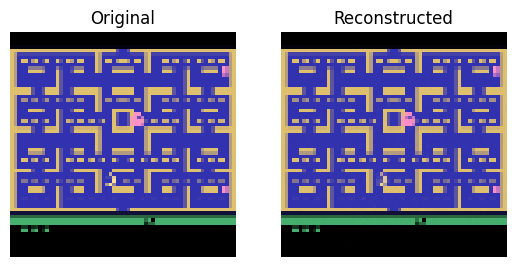

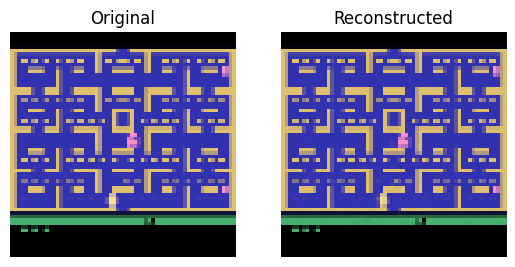

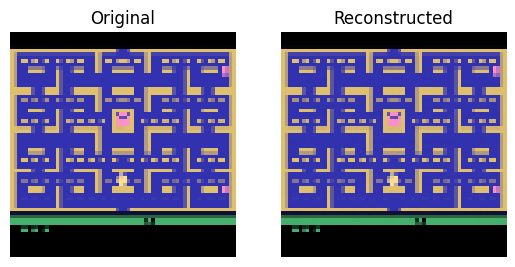

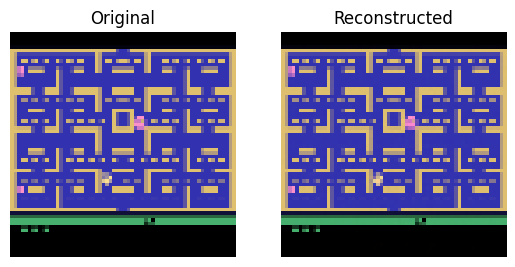

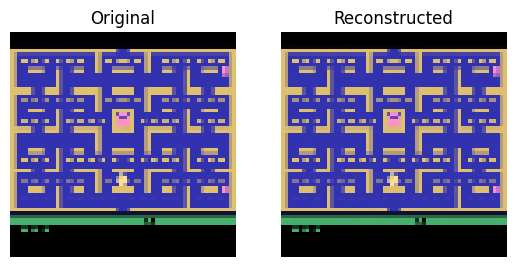

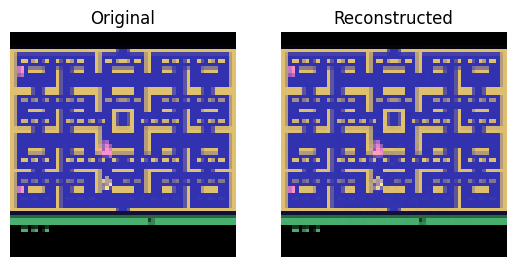

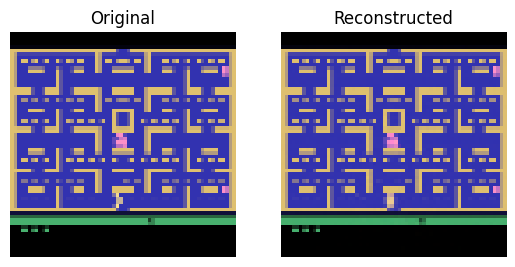

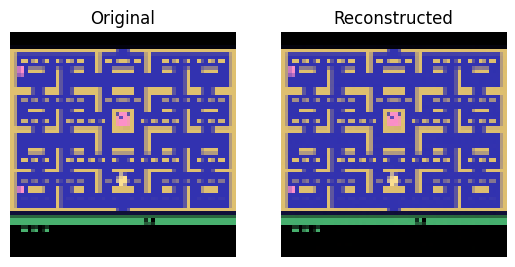

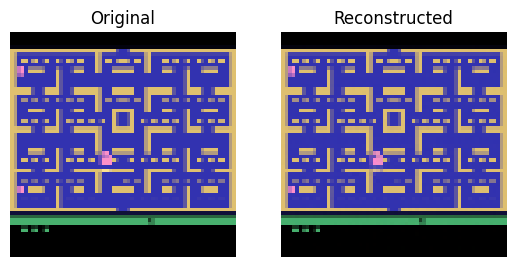

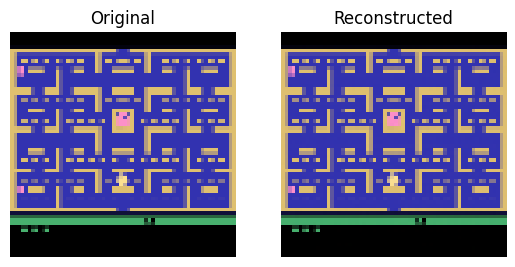

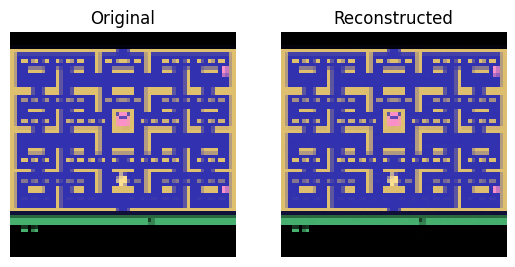

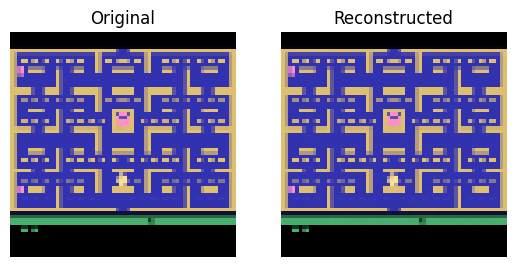

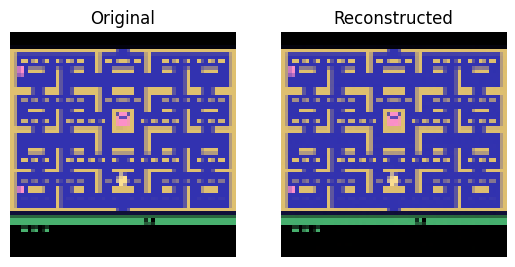

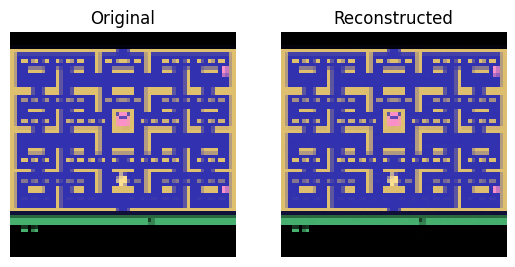

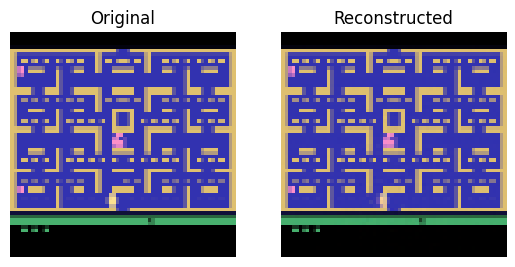

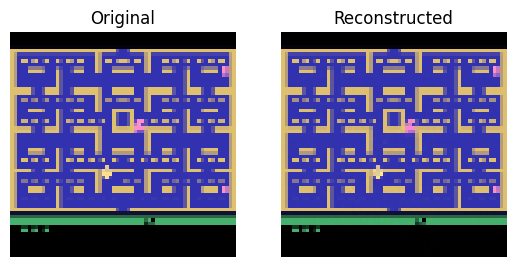

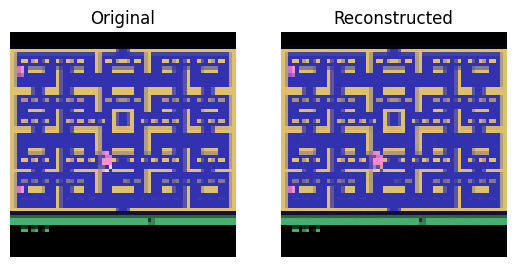

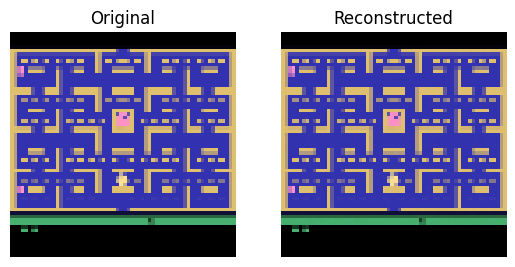

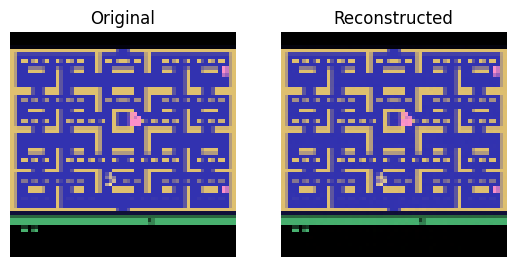

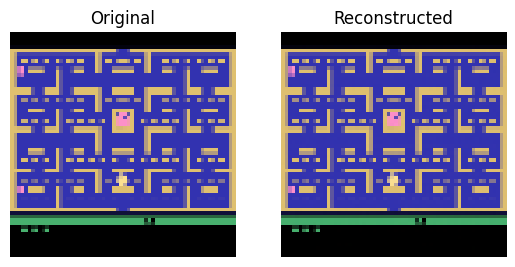

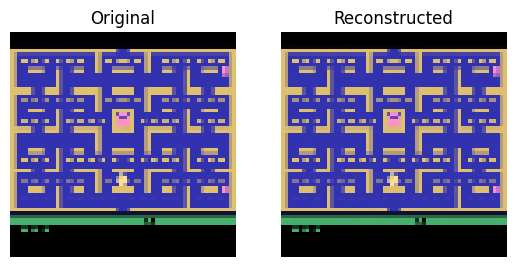

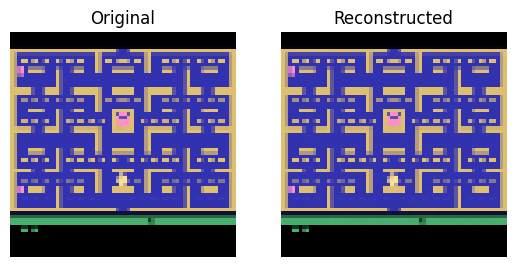

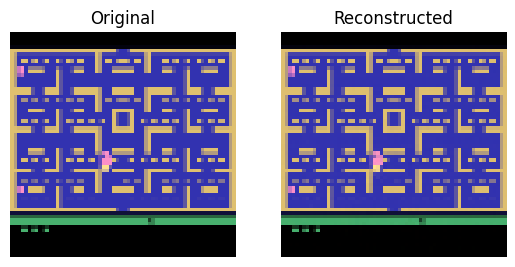

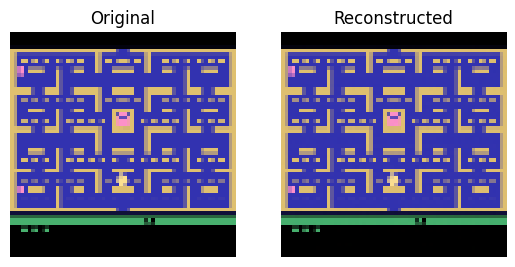

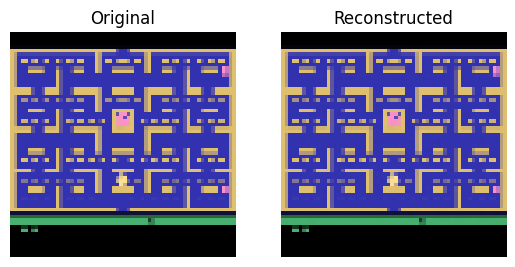

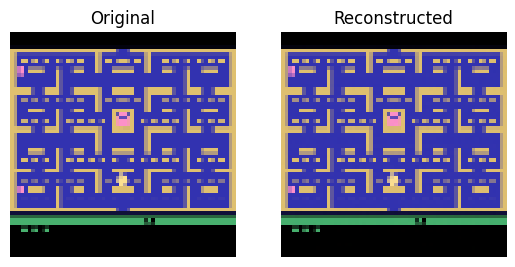

In [9]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze())
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze())
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


def eval_on_test_data(model: Model, num_examples: int, test_dataset):
    test_batches = test_dataset.unbatch().shuffle(100).batch(num_examples)
    test_images = next(iter(test_batches.take(1)))[0].numpy()
    reconst_images = np.clip(model.predict(test_images), 0.0, 1.0)
    for test_image, reconst_image in zip(test_images, reconst_images):
        show_subplot(test_image, reconst_image)


eval_on_test_data(model, 50, test_dataset)